In [1]:
# imports
from mne import Epochs, find_events, set_eeg_reference, read_epochs, concatenate_epochs, viz, combine_evoked
from time import time, strftime, gmtime
from collections import OrderedDict
from glob import glob
from collections import OrderedDict
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'app','utils','jupyter'))
import utils
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# loadCSV

files = ['C:/Users/jdpig/BrainWaves Workspaces/N170 Validate/Data/Subash/EEG/Subash-2-raw.csv']
replace_ch_names = None
# Note: in the app, the entire utils file is loaded and ran. Here, we have to use it as an import
raw = utils.load_data(files)

['C:/Users/jdpig/BrainWaves Workspaces/N170 Validate/Data/Subash/EEG/Subash-2-raw.csv']
Creating RawArray with float64 data, n_channels=15, n_times=16283
    Range : 0 ... 16282 =      0.000 ...   127.203 secs
Ready.


In [3]:
# filterIIR

low_cutoff = 1
high_cutoff = 30
raw.filter(low_cutoff, high_cutoff, method='iir');

Setting up band-pass filter from 1 - 30 Hz


Effective window size : 16.000 (s)


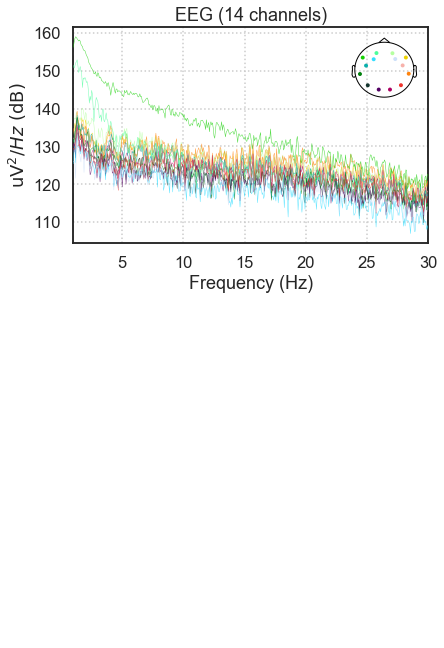

In [4]:
# PlotPSD

raw.plot_psd(fmin=1, fmax=30);

In [5]:
# epochEvents

event_id = {'Face': 1, 'House': 2}
tmin=-0.1
tmax=0.8
baseline = (tmin, tmax)
picks = None
reject = None
events = find_events(raw)
conditions = OrderedDict({key: [value] for (key, value) in event_id.items()})

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=tmin, tmax=tmax, baseline=baseline, reject=reject, preload=True, 
                verbose=False, picks=picks)

100 events found
Event IDs: [1 2]


In [6]:
# requestEpochsInfo

utils.get_epochs_info(epochs)

[{'Face': 51}, {'House': 49}, {'Drop Percentage': 0.0}, {'Total Epochs': 100}]

In [33]:
# requestChannelInfo

[ch for ch in epochs.ch_names if ch != 'Marker']

['AF3',
 'F7',
 'F3',
 'FC5',
 'T7',
 'P7',
 'O1',
 'O2',
 'P8',
 'T8',
 'FC6',
 'F4',
 'F8',
 'AF4']

Using matplotlib backend: Qt5Agg


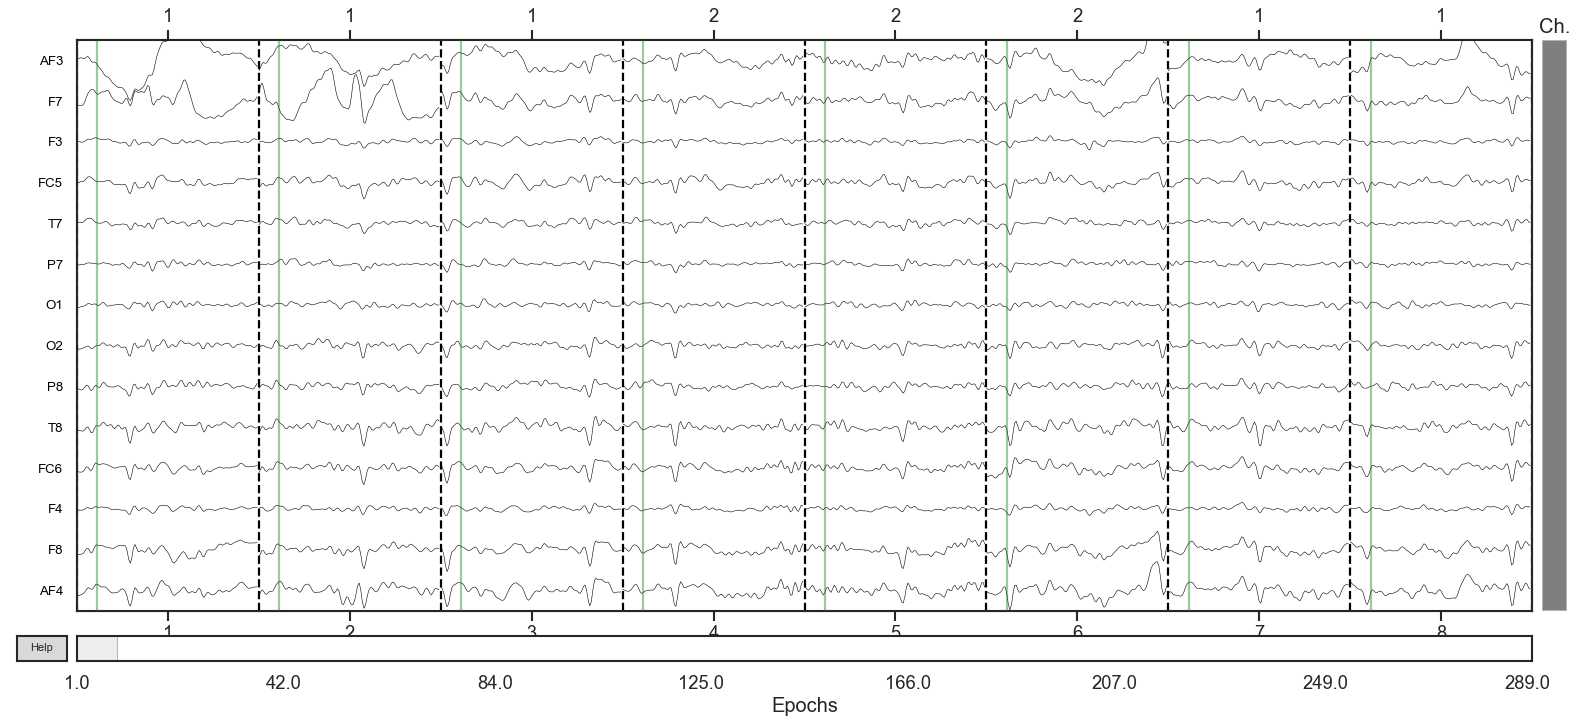

Dropped 0 epochs
Channels marked as bad: []


In [31]:
# cleanEpochsPlot
%matplotlib

clean_plot = epochs.plot(scalings='auto', n_epochs=8, title="", events=None);
for axis in clean_plot.axes:
    for line in axis.lines:
        line.set_linewidth(2)
        
clean_plot.show()

In [22]:
# saveEpochs

epochs.save('C:/Users/jdpig/BrainWaves Workspaces/N170 Validate/Data/Subash/EEG/example2-epo.fif')

In [34]:
# loadCleanedEpochs

files = ['C:/Users/jdpig/BrainWaves Workspaces/N170 Validate/Data/Subash/EEG/example-epo.fif', 'C:/Users/jdpig/BrainWaves Workspaces/N170 Validate/Data/Subash/EEG/example2-epo.fif']
epochs = concatenate_epochs([read_epochs(file) for file in files])
conditions = OrderedDict({key: [value] for (key, value) in epochs.event_id.items()})

Reading C:/Users/jdpig/BrainWaves Workspaces/N170 Validate/Data/Subash/EEG/example-epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     796.88 ms
        0 CTF compensation matrices available
100 matching events found
Applying baseline correction (mode: mean)
100 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Reading C:/Users/jdpig/BrainWaves Workspaces/N170 Validate/Data/Subash/EEG/example2-epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     796.88 ms
        0 CTF compensation matrices available
189 matching events found
Applying baseline correction (mode: mean)
189 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
289 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 bad epochs dropped


NameError: name 'axis_facecolor' is not defined

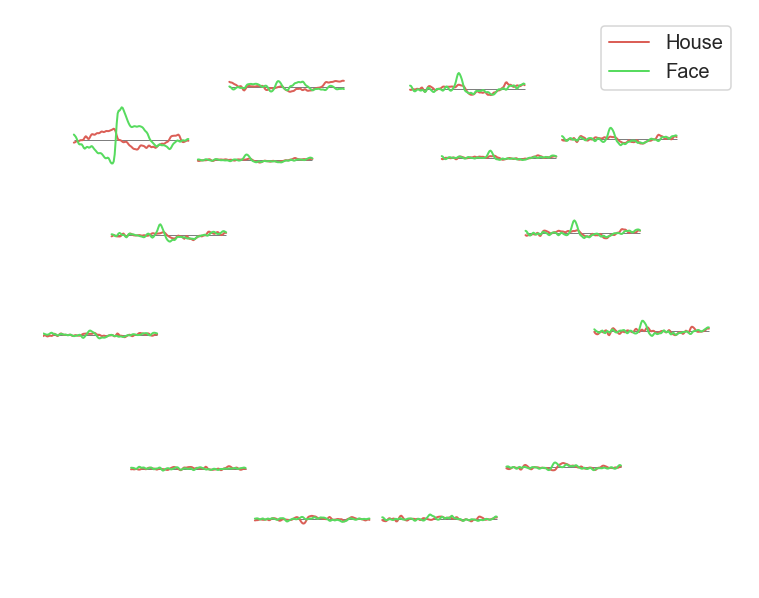

In [28]:
# plotTopoMap

def plot_topo(epochs, conditions=OrderedDict()):
    palette = sns.color_palette("hls", len(conditions) + 1)
    evokeds = [epochs[name].average() for name in (conditions)]

    evoked_topo = viz.plot_evoked_topo(
        evokeds, vline=None, color=palette[0:len(conditions)], show=False, legend=False);
    evoked_topo.patch.set_alpha(0)
    evoked_topo.set_size_inches(10,8)
    for axis in evoked_topo.axes:
        axis.patch.set_alpha(0)
        for line in axis.lines:
            line.set_linewidth(2)
            
    legend_loc = 0
    labels = [e.comment if e.comment else 'Unknown' for e in evokeds]
    legend = plt.legend(labels, loc=legend_loc, prop={'size': 20})
    legend.get_frame().set_facecolor(axis_facecolor)
    txts = legend.get_texts()
    for txt, col in zip(txts, palette):
        txt.set_color(col)
    
    return evoked_topo


%matplotlib inline
topo = plot_topo(epochs, conditions);

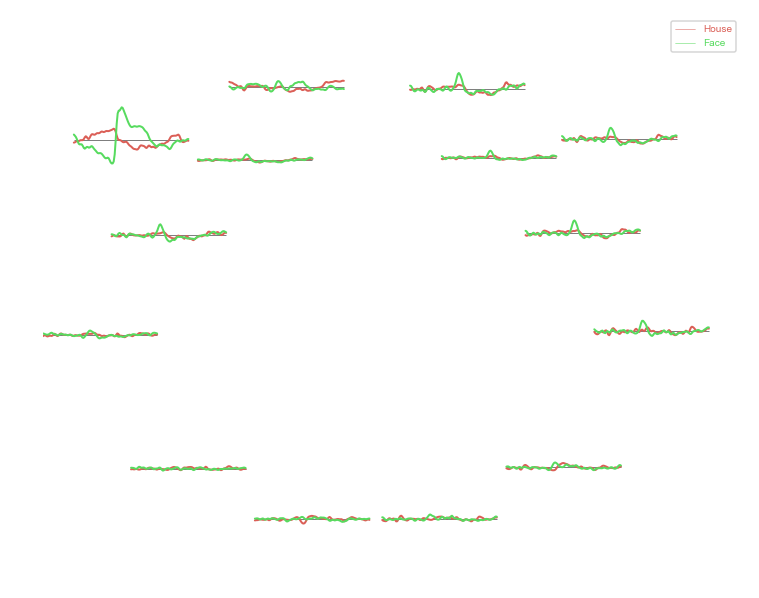

In [20]:
topo.set_size_inches(10, 8)
topo

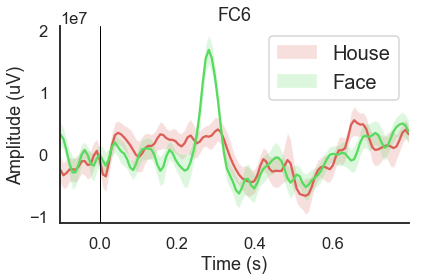

In [27]:
## Plot ERPs

# Input
ch_ind = 10

# Output
X, y = utils.plot_conditions(epochs, ch_ind=ch_ind, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='', diff_waveform=None)